In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"roshanupadhyay07","key":"24064c54065446c889ac2c912e483f8c"}'}

In [3]:
#Make a directory named kaggle and copy the kaggle.json file there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d andrewmvd/car-plate-detection

 95% 193M/203M [00:03<00:00, 113MB/s]
100% 203M/203M [00:03<00:00, 69.6MB/s]


In [7]:
!unzip car-plate-detection.zip

Archive:  car-plate-detection.zip
  inflating: annotations/Cars0.xml   
  inflating: annotations/Cars1.xml   
  inflating: annotations/Cars10.xml  
  inflating: annotations/Cars100.xml  
  inflating: annotations/Cars101.xml  
  inflating: annotations/Cars102.xml  
  inflating: annotations/Cars103.xml  
  inflating: annotations/Cars104.xml  
  inflating: annotations/Cars105.xml  
  inflating: annotations/Cars106.xml  
  inflating: annotations/Cars107.xml  
  inflating: annotations/Cars108.xml  
  inflating: annotations/Cars109.xml  
  inflating: annotations/Cars11.xml  
  inflating: annotations/Cars110.xml  
  inflating: annotations/Cars111.xml  
  inflating: annotations/Cars112.xml  
  inflating: annotations/Cars113.xml  
  inflating: annotations/Cars114.xml  
  inflating: annotations/Cars115.xml  
  inflating: annotations/Cars116.xml  
  inflating: annotations/Cars117.xml  
  inflating: annotations/Cars118.xml  
  inflating: annotations/Cars119.xml  
  inflating: annotations/Cars12.xm

In [8]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

In [9]:
import os
for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/kaggle.json
/content/car-plate-detection.zip
/content/.config/.last_survey_prompt.yaml
/content/.config/.last_update_check.json
/content/.config/.last_opt_in_prompt.yaml
/content/.config/config_sentinel
/content/.config/gce
/content/.config/active_config
/content/.config/logs/2023.04.14/13.33.49.775521.log
/content/.config/logs/2023.04.14/13.33.23.944257.log
/content/.config/logs/2023.04.14/13.34.46.037681.log
/content/.config/logs/2023.04.14/13.34.12.944578.log
/content/.config/logs/2023.04.14/13.34.45.328952.log
/content/.config/logs/2023.04.14/13.34.21.160489.log
/content/.config/configurations/config_default
/content/images/Cars89.png
/content/images/Cars39.png
/content/images/Cars188.png
/content/images/Cars100.png
/content/images/Cars330.png
/content/images/Cars109.png
/content/images/Cars350.png
/content/images/Cars64.png
/content/images/Cars425.png
/content/images/Cars262.png
/content/images/Cars305.png
/content/images/Cars283.png
/content/images/Cars339.png
/content/i

In [10]:
IMAGE_SIZE = 200

In [11]:
img_dir = "/content/images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

In [12]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]
        

In [13]:
path = '/content/annotations'
text_files = ['/content/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [14]:
resizeannotation("/content/annotations/Cars147.xml")

[168, 126, 90, 93]

In [15]:
y[0]

[167, 129, 90, 93]

In [16]:
np.array(X).shape

(433, 200, 200, 3)

In [17]:
np.array(y).shape

(433, 4)

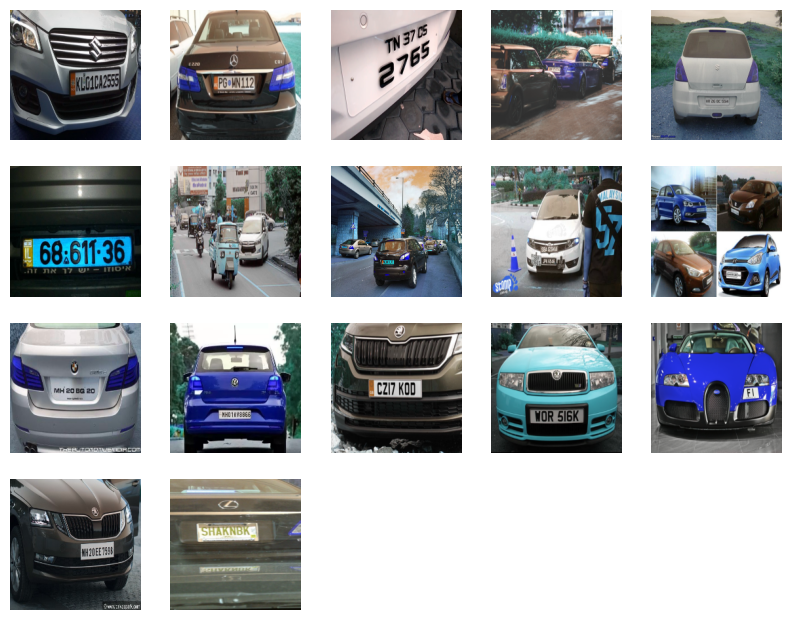

In [18]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

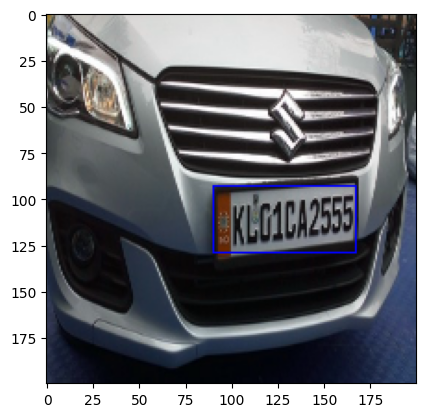

In [19]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


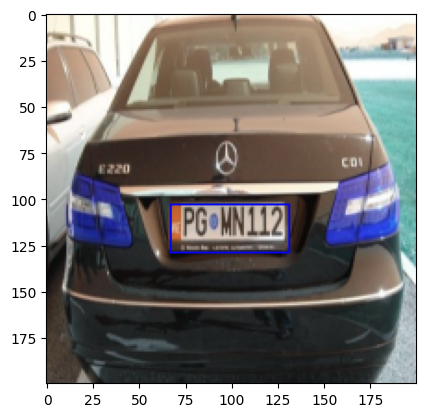

In [20]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


In [21]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [22]:
#Renormalisation
X = X / 255
y = y / 255

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

## Convolutionnal Neural Network

In [24]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

In [25]:
# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2359424   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                         

In [26]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [29]:
train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, batch_size=16, verbose=1)

Epoch 1/300
25/25 [==============================] - 2s 73ms/step - loss: 4.2805e-04 - accuracy: 0.9409 - val_loss: 0.0039 - val_accuracy: 0.9091
Epoch 2/300
25/25 [==============================] - 2s 72ms/step - loss: 4.2094e-04 - accuracy: 0.9614 - val_loss: 0.0039 - val_accuracy: 0.8409
Epoch 3/300
25/25 [==============================] - 2s 67ms/step - loss: 4.4832e-04 - accuracy: 0.9434 - val_loss: 0.0046 - val_accuracy: 0.8864
Epoch 4/300
25/25 [==============================] - 2s 68ms/step - loss: 8.3326e-04 - accuracy: 0.9229 - val_loss: 0.0044 - val_accuracy: 0.9545
Epoch 5/300
25/25 [==============================] - 2s 70ms/step - loss: 6.2661e-04 - accuracy: 0.9152 - val_loss: 0.0046 - val_accuracy: 0.8636
Epoch 6/300
25/25 [==============================] - 2s 67ms/step - loss: 6.3899e-04 - accuracy: 0.9306 - val_loss: 0.0040 - val_accuracy: 0.9091
Epoch 7/300
25/25 [==============================] - 2s 68ms/step - loss: 6.1104e-04 - accuracy: 0.9280 - val_loss: 0.0039 -

In [30]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 90.91%


In [31]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

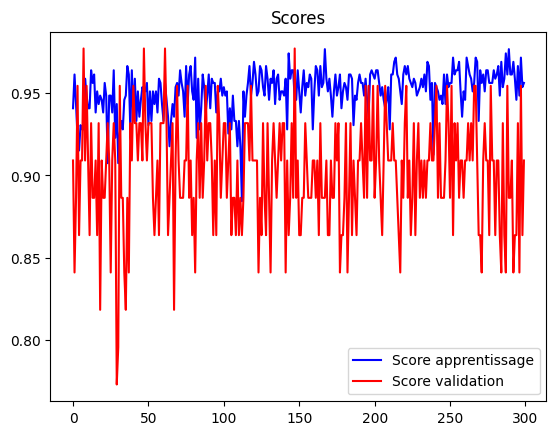

In [32]:
plot_scores(train)

## DETECTION 

In [33]:
y_cnn = model.predict(X_test)

2/2 [==============================] - 0s 132ms/step


In [34]:
y_cnn.shape

(44, 4)

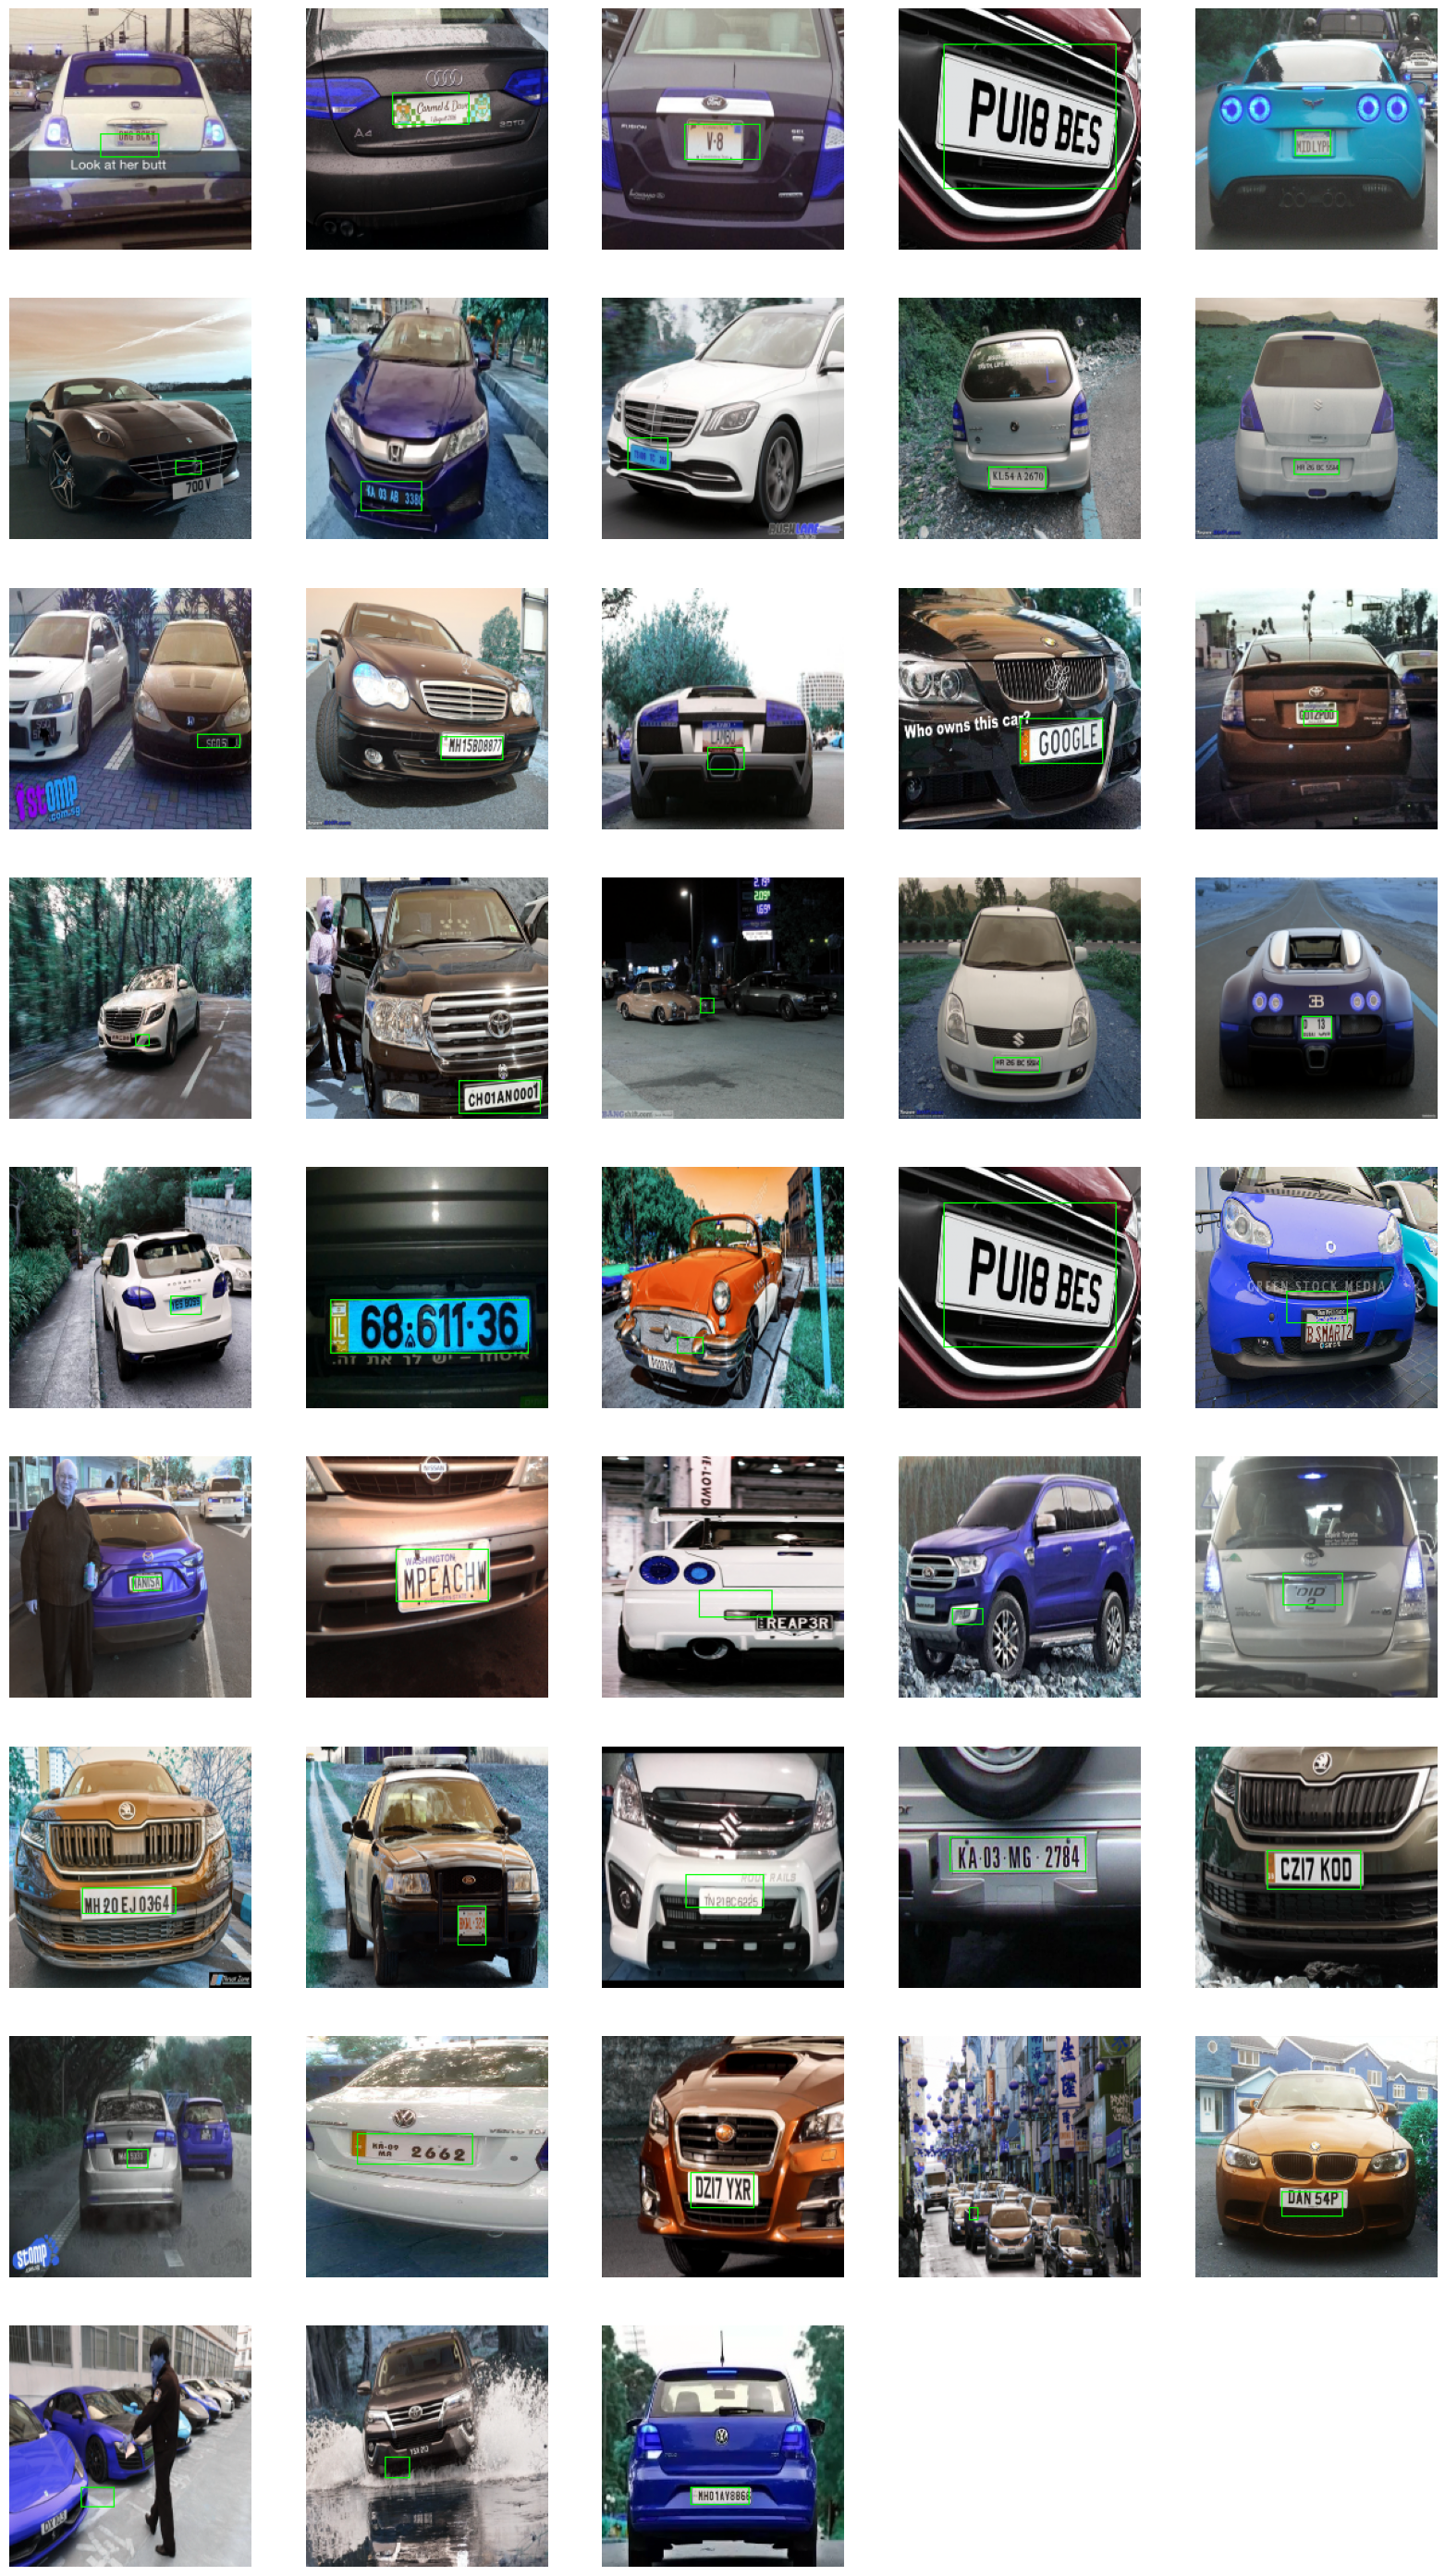

In [35]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)